In [1]:
import functools
import tensorflow as tf
from core.model import ModelMNIST10x10_base, swish
from core.hessian import diagonal_hessians_highrank

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(0.1, 0.0, use_nesterov=True)):
        self.batch_ratio = max(1.0, 1.0 * batch_size / 50000.0)
        super(Implement, self).__init__(batch_size, opt, activation=tf.nn.relu)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        hessis = diagonal_hessians_highrank(
                 cost, var_refs, gradients=grads,
                 aggregation_method=None, colocate_gradients_with_ops=True)
        
        second_order_grads = []
        for l, g, h, v in zip(range(len(grads)), grads, hessis, var_refs):
            shape = g.shape
            is_calculating_hessian = True#('conv' in v.name)# and ('weight' in v.name)
            if is_calculating_hessian:
                d = int(functools.reduce(lambda a,b: a*b, shape))
        
                h_inv = 1.0 / (tf.reshape(h + 1e-6, shape))
                h_inv_clipped = tf.clip_by_value(h_inv, -1.0, +1.0)
                
                delta = tf.multiply(h_inv_clipped, g)
            else:
                delta = g
            second_order_grads.append(delta)
            
            tf.summary.histogram('{}'.format(v.name.replace(':', '_')), v)
            tf.summary.histogram('{}/gradient'.format(v.name.replace(':', '_')), g)
            tf.summary.histogram('{}/delta'.format(v.name.replace(':', '_')), delta)
            if is_calculating_hessian:
                tf.summary.histogram('{}/hessian/diag'.format(v.name.replace(':', '_')), h)
                tf.summary.histogram('{}/hessian/inv/diag'.format(v.name.replace(':', '_')), h_inv)
                tf.summary.histogram('{}/hessian/inv/clip/diag'.format(v.name.replace(':', '_')), h_inv_clipped)
            
        return second_order_grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

model = Implement(batch_size=128)

[1204 13:36:16 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1204 13:36:17 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [3]:
from core.utils import loop

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=config)
history = loop(sess, model, 30, './summary/8_3_incomplete_second_order_optimization_batch_128')

env: CUDA_VISIBLE_DEVICES=0
[INFO] session initialized
[INFO] [0000] [train] cost:0.275 accuracy:0.388 elapsed:14.252sec [valid] cost:0.232 accuracy:0.511 elapsed:0.305sec
[INFO] [0001] [train] cost:0.225 accuracy:0.542 elapsed:11.907sec [valid] cost:0.205 accuracy:0.603 elapsed:0.131sec
[INFO] [0002] [train] cost:0.185 accuracy:0.665 elapsed:12.029sec [valid] cost:0.167 accuracy:0.707 elapsed:0.134sec
[INFO] [0003] [train] cost:0.155 accuracy:0.735 elapsed:11.855sec [valid] cost:0.149 accuracy:0.748 elapsed:0.127sec
[INFO] [0004] [train] cost:0.142 accuracy:0.766 elapsed:11.493sec [valid] cost:0.142 accuracy:0.766 elapsed:0.125sec
[INFO] [0005] [train] cost:0.152 accuracy:0.742 elapsed:11.369sec [valid] cost:0.163 accuracy:0.710 elapsed:0.135sec
[INFO] [0006] [train] cost:0.161 accuracy:0.715 elapsed:11.409sec [valid] cost:0.164 accuracy:0.705 elapsed:0.131sec
[INFO] [0007] [train] cost:0.154 accuracy:0.728 elapsed:11.467sec [valid] cost:0.167 accuracy:0.691 elapsed:0.134sec
[INFO] [0

average elapsed time train:11.989577sec valid:0.132715sec


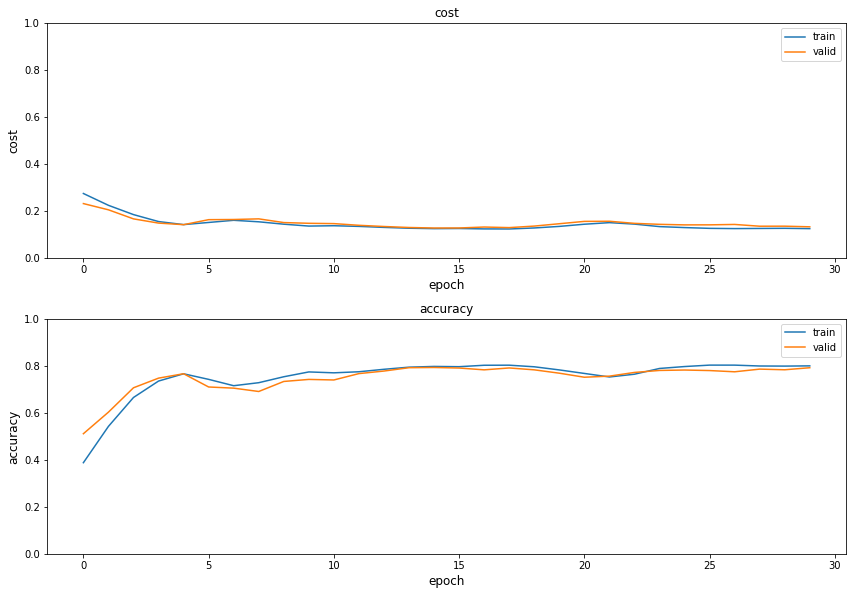

In [4]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)